## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
import warnings
warnings.filterwarnings('ignore')

# Pricing 

## Method 1 Revenue Maximization

find out the optimal price that maximises revenue.

In [2]:
# Pricing data
pricing = pd.DataFrame({
    'prices': [100, 90, 70, 60, 40, 20, 10],
    'demand': [100, 120, 200, 300, 1200, 2000, 2800]
})

# Custom optimization for revenue maximizing price
def calculate_revenue_maximizing_price(prices, demand, lower_bound, upper_bound):
    
    best_price = None
    max_revenue = 0

    for current_price in prices:
        revenue = current_price*demand[prices == current_price].values[0]
        
        if revenue > max_revenue:
            max_revenue = revenue
            best_price = current_price

    return best_price

# Find the optimal price
lower_bound = min(pricing['prices'])
upper_bound = max(pricing['prices'])
optimal_price = calculate_revenue_maximizing_price(pricing['prices'], pricing['demand'], lower_bound, upper_bound)
print("Optimal Price for Revenue Maximization:", optimal_price)

Optimal Price for Revenue Maximization: 40


## Method 2 Revenue Maximization


find out the optimal price that maximises revenue.


Degree 1 - Optimal Price: 44, Max Revenue: 57441, RMSE: 362.4687663197714

Degree 2 - Optimal Price: 30, Max Revenue: 46309, RMSE: 78.61119476789985

Degree 3 - Optimal Price: 30, Max Revenue: 46229, RMSE: 78.59330557426014

Degree 4 - Optimal Price: 30, Max Revenue: 46255, RMSE: 78.58846410653676


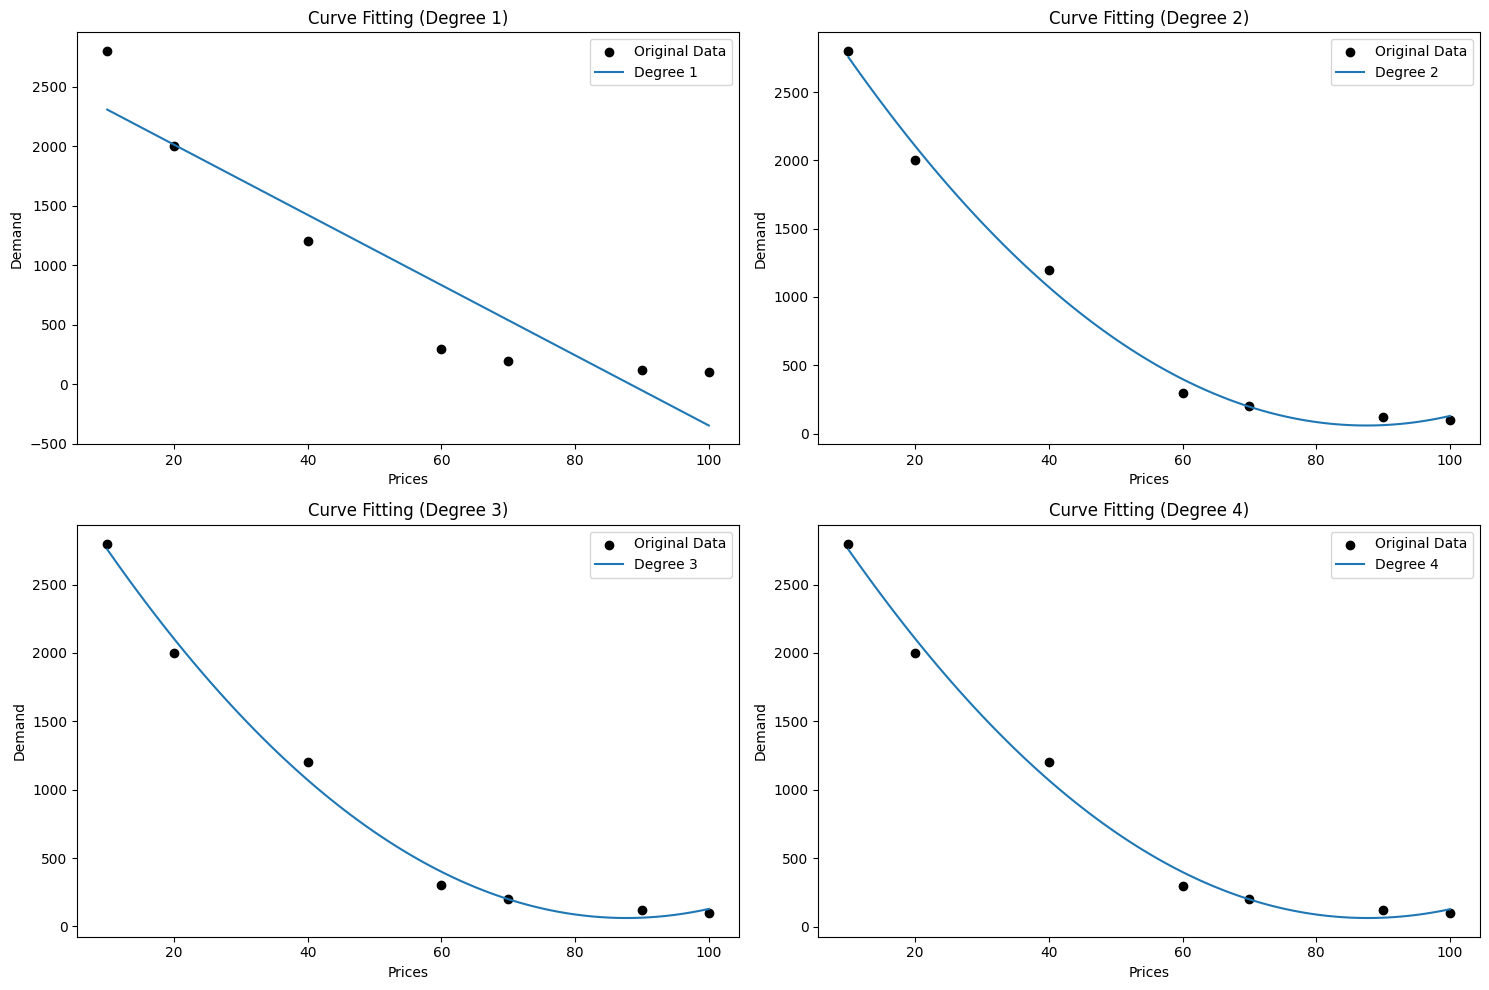

In [3]:
# Pricing data
pricing = pd.DataFrame({
    'prices': [100, 90, 70, 60, 40, 20, 10],
    'demand': [100, 120, 200, 300, 1200, 2000, 2800]
})

# Define the function for the curve fit (polynomial in this case)
def curve_fit_function(x, *coefficients):
    return np.polyval(coefficients, x)

# Different polynomial degrees to try
degrees_to_try = [1, 2, 3, 4]

plt.figure(figsize=(15, 10))

for i, degree in enumerate(degrees_to_try, start=1):
    plt.subplot(2, 2, i)
    
    # Fit the curve to the pricing data
    coefficients, covariance = np.polyfit(pricing['prices'], pricing['demand'], degree, cov=True)
    
    # Generate smooth curve values
    smooth_prices = np.linspace(pricing['prices'].min(), pricing['prices'].max(), 100)
    smooth_demand = curve_fit_function(smooth_prices, *coefficients)
    
    # Plot the fitted curve
    plt.scatter(pricing['prices'], pricing['demand'], label='Original Data', color='black')
    plt.plot(smooth_prices, smooth_demand, label=f'Degree {degree}')
    plt.title(f'Curve Fitting (Degree {degree})')
    plt.xlabel('Prices')
    plt.ylabel('Demand')
    plt.legend()

    # Calculate revenue for the current curve
    revenue = lambda price: -curve_fit_function(price, *coefficients) * price
    result = minimize_scalar(revenue, bounds=(10, 100), method='bounded')
    optimal_price = round(result.x)
    max_revenue = round(-result.fun)

    # Calculate RMSE
    predicted_demand = curve_fit_function(pricing['prices'], *coefficients)
    rmse = np.sqrt(mean_squared_error(pricing['demand'], predicted_demand))
    
    print(f"\nDegree {degree} - Optimal Price: {optimal_price}, Max Revenue: {max_revenue}, RMSE: {rmse}")

plt.tight_layout()
plt.show()

## Profit Maximization

find the price that maximizes our profits.

Optimal Price for Profit Maximization (using Polynomial Fit): 33
Max Profit: 40396


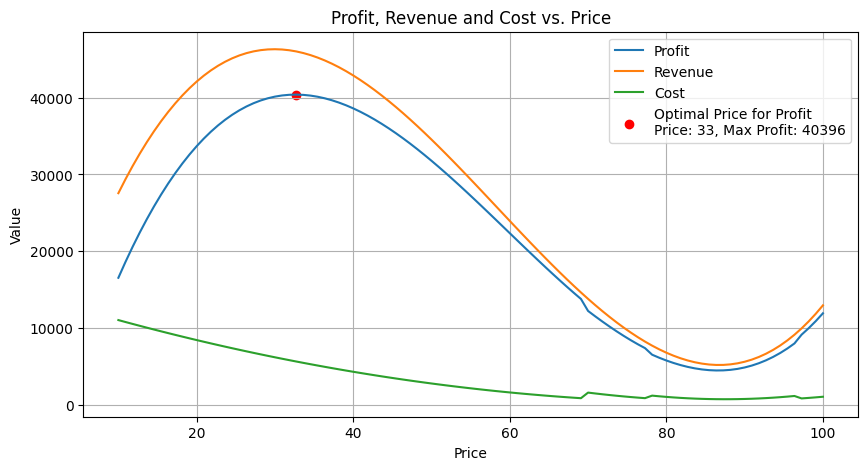

In [4]:
# Supplier pricing table
supplier_pricing = pd.DataFrame({
    'quantity': [50, 100, 200, np.inf],
    'supplier_price': [15, 12, 8, 4],
})

# Pricing data
pricing = pd.DataFrame({
    'prices': [100, 90, 70, 60, 40, 20, 10],
    'demand': [100, 120, 200, 300, 1200, 2000, 2800]
})

# Get the supplier price based on the quantity
def get_supplier_price(quantity):
    for idx, row in supplier_pricing.iterrows():
        if quantity <= row['quantity']:
            return row['supplier_price']
    return supplier_pricing.iloc[-1]['supplier_price']

# Define the polynomial fit function for demand
def demand_fit_function(x, *coefficients):
    return np.polyval(coefficients, x)

# Define the revenue function for optimization
def calculate_revenue(price, coefficients):
    demand = demand_fit_function(price, *coefficients)
    return price * demand
    
# Define the cost function
def calculate_cost(price, coefficients):
    demand = demand_fit_function(price, *coefficients)
    supplier_price = get_supplier_price(demand)
    return demand * supplier_price

# Define the profit function
def calculate_profit(price, coefficients):
    revenue = calculate_revenue(price, coefficients)
    cost = calculate_cost(price, coefficients)
    return revenue - cost

# Fit a quadratic polynomial to the demand data
coefficients_demand, _ = np.polyfit(pricing['prices'], pricing['demand'], 2, cov=True)

# Find the price that maximizes profits using polynomial fit
result = minimize_scalar(lambda price: -calculate_profit(price, coefficients_demand), bounds=(10, 100), method='bounded')
optimal_price_profit = result.x
max_profit = -result.fun

# Generate prices for plotting
plot_prices = np.linspace(10, 100, 100)

# Calculate profit, revenue, and cost for the given prices
profits = [calculate_profit(p, coefficients_demand) for p in plot_prices]
revenues = [calculate_revenue(p, coefficients_demand) for p in plot_prices]
costs = [calculate_cost(p, coefficients_demand) for p in plot_prices]

print("Optimal Price for Profit Maximization (using Polynomial Fit):", round(optimal_price_profit))
print("Max Profit:", round(max_profit))

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(plot_prices, profits, label='Profit')
plt.plot(plot_prices, revenues, label='Revenue')
plt.plot(plot_prices, costs, label='Cost')

plt.scatter(optimal_price_profit, max_profit, color='red', 
            label=f'Optimal Price for Profit\nPrice: {optimal_price_profit:.0f}, Max Profit: {max_profit:.0f}')

plt.title('Profit, Revenue and Cost vs. Price')
plt.xlabel('Price')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Regression

## Load sales data

In [5]:
# Load the sales data
file_path = 'sales.csv'
sales_data = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
df = sales_data.copy()

In [6]:
df.head()

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt
date,,,,,,,
2018-09-27,19194,21046,12573,10720,3309,9791,26523
2018-10-04,13292,14721,6916,7645,2557,6981,17594
2018-10-11,19954,20708,7495,9138,3632,9956,23666
2018-10-18,17547,20016,7913,9693,3565,7894,20586
2018-10-25,17420,20397,8887,12132,3415,7495,19395


## EDA

### Frequency of the data

In [7]:
# Identify the frequency of the time series
frequency = pd.infer_freq(df.index)

print("Inferred Frequency:", frequency)

Inferred Frequency: W-THU


### Data information

In [8]:
df.describe()

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,14372.912621,31115.631068,4555.524272,5675.077670,11146.873786,8951.854369,21097.815534
std,4960.983339,15542.548614,2536.274197,2456.244011,12513.506661,3134.279560,8849.700921
min,6718.000000,14134.000000,825.000000,2405.000000,1001.000000,5010.000000,6277.000000
25%,10525.500000,19910.500000,2686.000000,3698.500000,2280.500000,6744.000000,13732.500000
50%,12837.000000,24677.000000,4163.000000,5398.000000,3857.000000,8130.000000,20333.000000
75%,17546.500000,36949.000000,6015.500000,7078.000000,17224.500000,10174.000000,26434.000000
max,35598.000000,91052.000000,12696.000000,14411.000000,63788.000000,21842.000000,49272.000000


In [9]:
df.max()/df.mean()

Blouse     2.476742
Dress      2.926246
Hoodie     2.786946
Jacket     2.539349
Shorts     5.722501
Skirt      2.439941
T-shirt    2.335408
dtype: float64

### Check missing data

In [10]:
def check_history_length_and_missing_dates(data):
    # Check length of history
    history_length = len(data)

    # Identify start and end dates
    start_date = data.index.min()
    end_date = data.index.max()

    # Generate a complete date range based on the frequency
    complete_date_range = pd.date_range(start=start_date, end=end_date, freq=pd.infer_freq(data.index))

    # Find missing dates
    missing_dates = complete_date_range.difference(data.index)

    # Print information
    print("Start Date:", start_date)
    print("End Date:", end_date)
    print("Length of Historical Data:", history_length)
    print("Missing Dates:", missing_dates)
    print("Number of Missing Dates:", len(missing_dates))

check_history_length_and_missing_dates(df)

Start Date: 2018-09-27 00:00:00
End Date: 2020-09-10 00:00:00
Length of Historical Data: 103
Missing Dates: DatetimeIndex([], dtype='datetime64[ns]', freq='W-THU')
Number of Missing Dates: 0


### Visualize time-series data for different product types

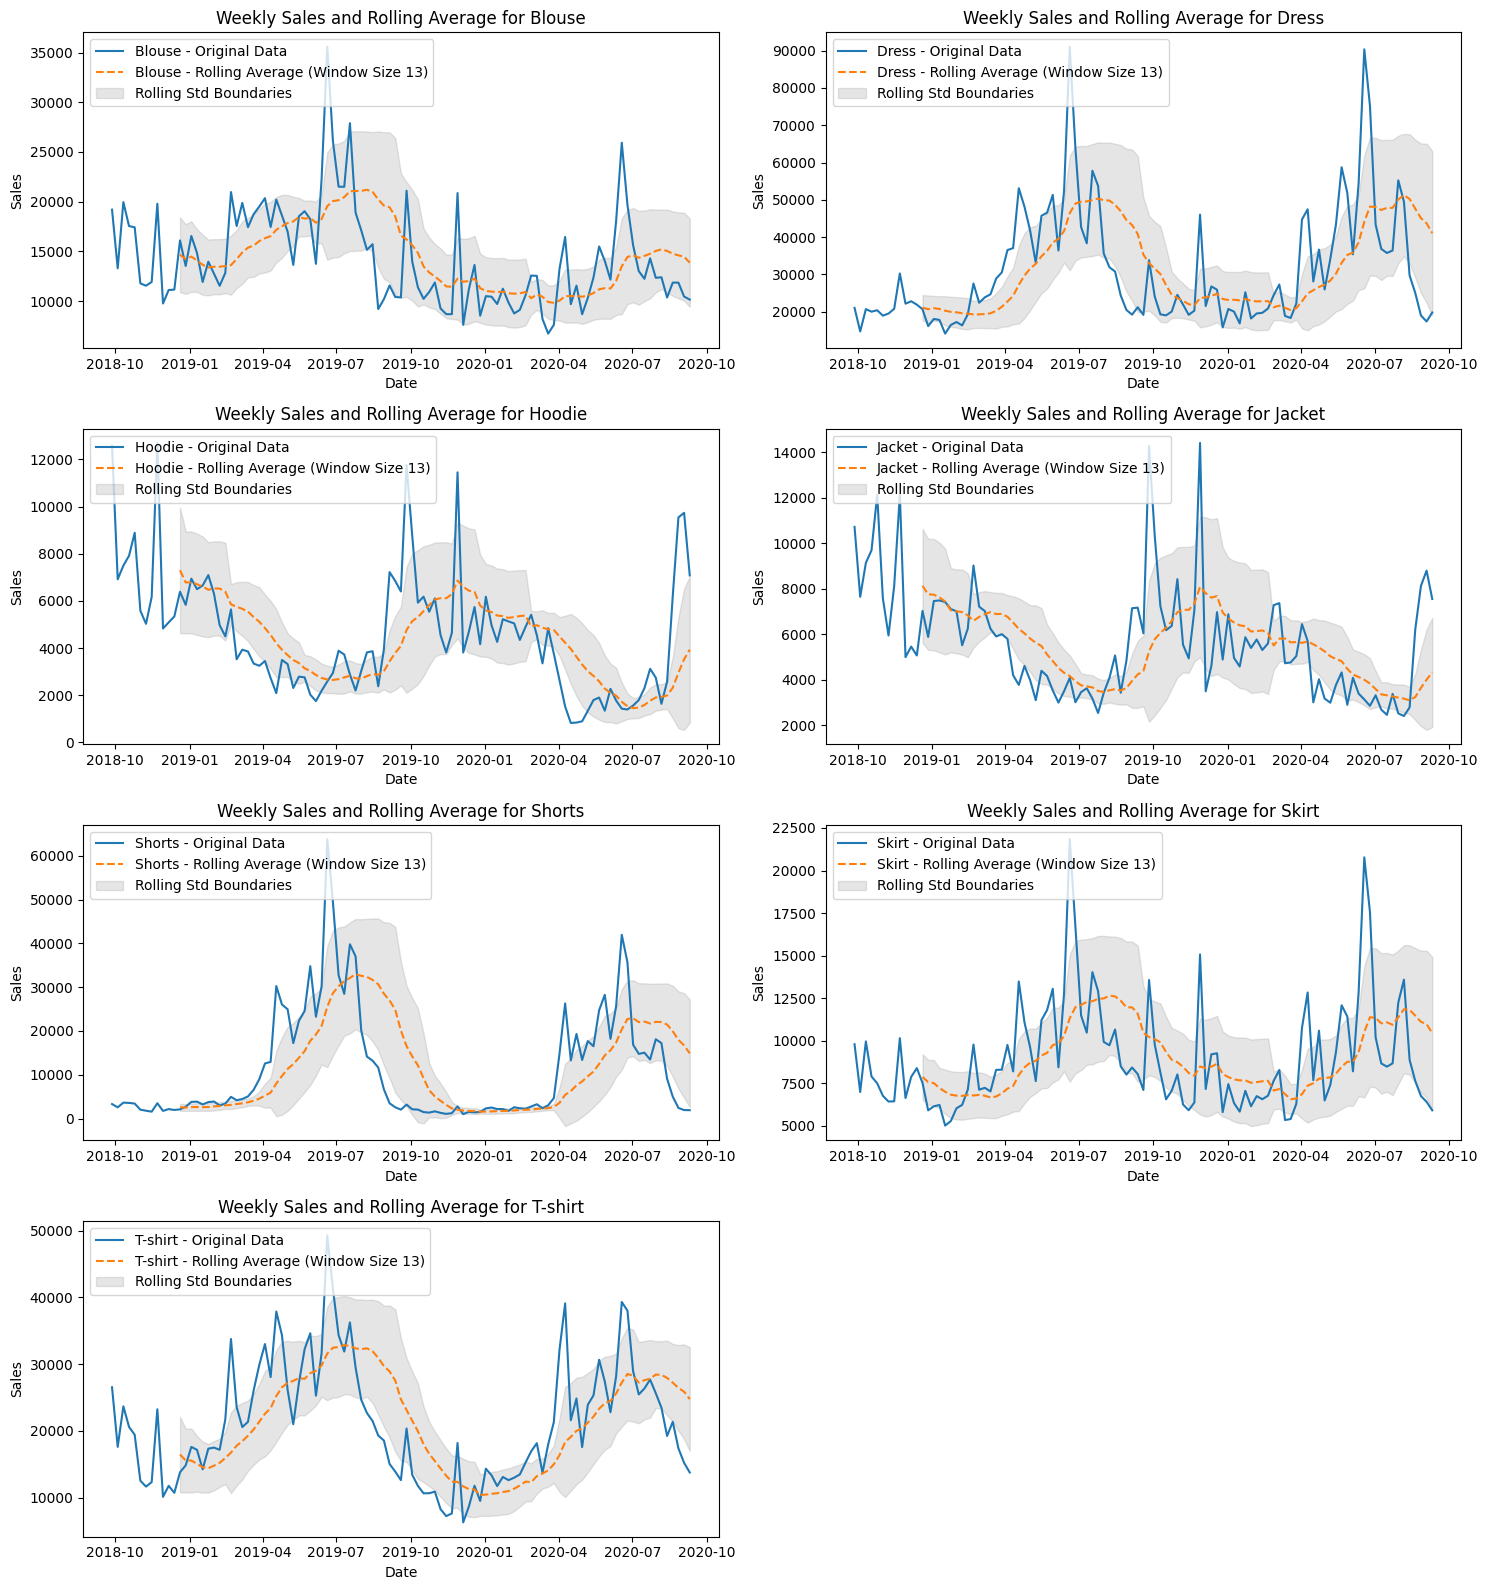

In [11]:
def plot_sales_and_rolling_average(df, window_size=7):
    num_columns = len(df.columns)
    num_rows = (num_columns + 1) // 2  # Ensure an extra row if the number of columns is odd

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plotting original data and rolling average for each product type
    for i, column in enumerate(df.columns):
        # Plotting original data
        axes[i].plot(df.index, df[column], label=f'{column} - Original Data')

        # Plotting rolling average
        rolling_average = df[column].rolling(window=window_size).mean()
        rolling_std = df[column].rolling(window=window_size).std()
        axes[i].plot(df.index, rolling_average, label=f'{column} - Rolling Average (Window Size {window_size})', 
                     linestyle='dashed')
        
        # Plot boundaries using rolling std
        axes[i].fill_between(df.index, rolling_average - rolling_std, 
                     rolling_average + rolling_std, color='gray', alpha=0.2, label='Rolling Std Boundaries')

        axes[i].set_title(f'Weekly Sales and Rolling Average for {column}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Sales')
        axes[i].legend(loc='upper left')

    # If the number of subplots is odd, remove the empty subplot
    if num_columns % 2 == 1:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

plot_sales_and_rolling_average(df, window_size=13)

### Stationarity

* ADF Statistic: The test statistic from the ADF test. If it is less than the critical values, it suggests stationarity.

* p-value: The probability that the null hypothesis (H0) is true. A lower p-value indicates stronger evidence against the null hypothesis.

* Critical Values: The critical values for different confidence levels. If the ADF Statistic is less than these critical values, you can reject the null hypothesis.

* ARIMA requires stationary time series data to capture and model auto-regressive and moving average relationships effectively

#### Dress Sales Data

In [12]:
def test_stationarity(timeseries):
    
    # Perform ADF test
    result = adfuller(timeseries, autolag='AIC')
    
    # Extract ADF Statistic, p-value, and Critical Values
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    
    # Interpretation of the result
    if p_value <= 0.05:
        print("Reject the null hypothesis (H0): The time series is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")

    # Print the critical values for reference
    print("\nCritical Values:")
    for key, value in critical_values.items():
        print(f"{key}: {value}")

test_stationarity(df['Dress'])

ADF Statistic: -2.14471851757982
p-value: 0.22691717793198252
Fail to reject the null hypothesis (H0): The time series is non-stationary.

Critical Values:
1%: -3.498198082189098
5%: -2.891208211860468
10%: -2.5825959973472097


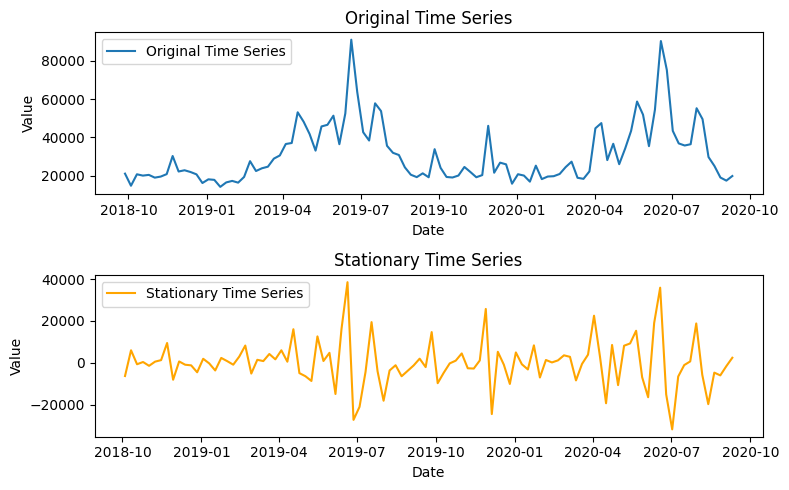

ADF Statistic: -9.028359669824003
p-value: 5.530799940581878e-15
Reject the null hypothesis (H0): The time series is stationary.

Critical Values:
1%: -3.498198082189098
5%: -2.891208211860468
10%: -2.5825959973472097


In [13]:
# Function to make time series stationary
def make_stationary(timeseries, difference_order=1):
    # Differencing
    if difference_order > 0:
        timeseries_diff = timeseries.diff(difference_order)
        timeseries_diff = timeseries_diff.dropna()  # Drop NaN values introduced by differencing
    else:
        timeseries_diff = timeseries.copy()

    return timeseries_diff

# Function to perform Augmented Dickey-Fuller Test for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    
    if p_value <= 0.05:
        print("Reject the null hypothesis (H0): The time series is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")
    
    print("\nCritical Values:")
    for key, value in critical_values.items():
        print(f"{key}: {value}")

# Make the time series stationary
stationary_series = make_stationary(df['Dress'], difference_order=1)

# Plotting
plt.figure(figsize=(8, 5))

# Original Time Series
plt.subplot(2, 1, 1)
plt.plot(df['Dress'], label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Stationary Time Series
plt.subplot(2, 1, 2)
plt.plot(stationary_series, label='Stationary Time Series', color='orange')
plt.title('Stationary Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Perform ADF test on the stationary series
test_stationarity(stationary_series)

### ACF, PACF plot

The ACF plot can provide answers to the following questions:

1. Is the observed time series white noise / random?
2. Is an observation related to an adjacent observation and so on?
3. Can the observed time series be modeled with an MA model? If yes, what is the order?

The PACF plot can provide answers to the following questions:

1. Can the observed time series be modeled with an AR model? If yes, what is the order?

* Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

* There is a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

#### Dress Sales Data - Stationary time series

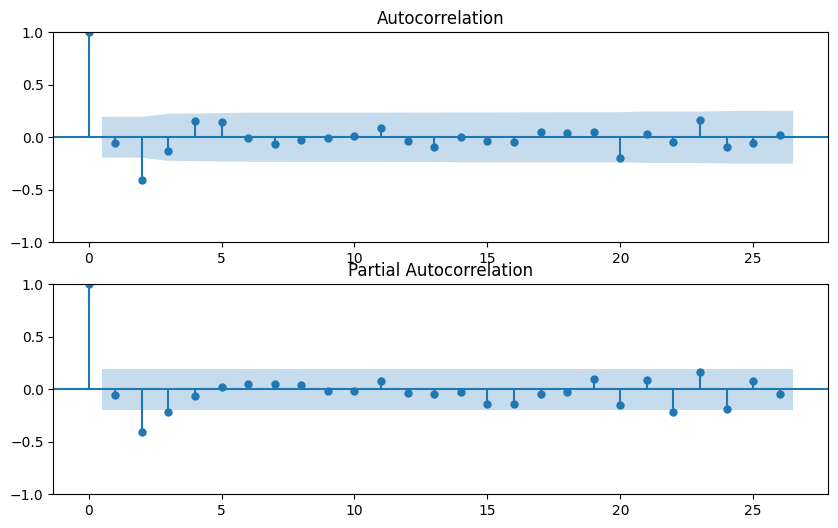

In [14]:
# Function to plot autocorrelation and partial autocorrelation functions
def plot_acf_pacf(timeseries, lags=30):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(timeseries, lags=lags, ax=ax1)
    plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
# Autocorrelation and Partial Autocorrelation Analysis
plot_acf_pacf(stationary_series, lags=26)

#### Conclusion

* Applied a first-order difference(d=1) to remove trends and seasonality from the original time series.
* ACF Analysis: Prominent spike at lag 2 implies a potential value of MA(q)=2. 
* PACF Analysis: Spikes at lags 2 and 3 suggest potential values for AR(p) as {2,3}.
* The seasonal order (m) for the time series is set to 52, representing the weekly frequency. Considering yearly seasonality, a spike at lag 52 is anticipated, leading to a value of Q as 1. 

### STL Decomposition

#### Dress Sales Data

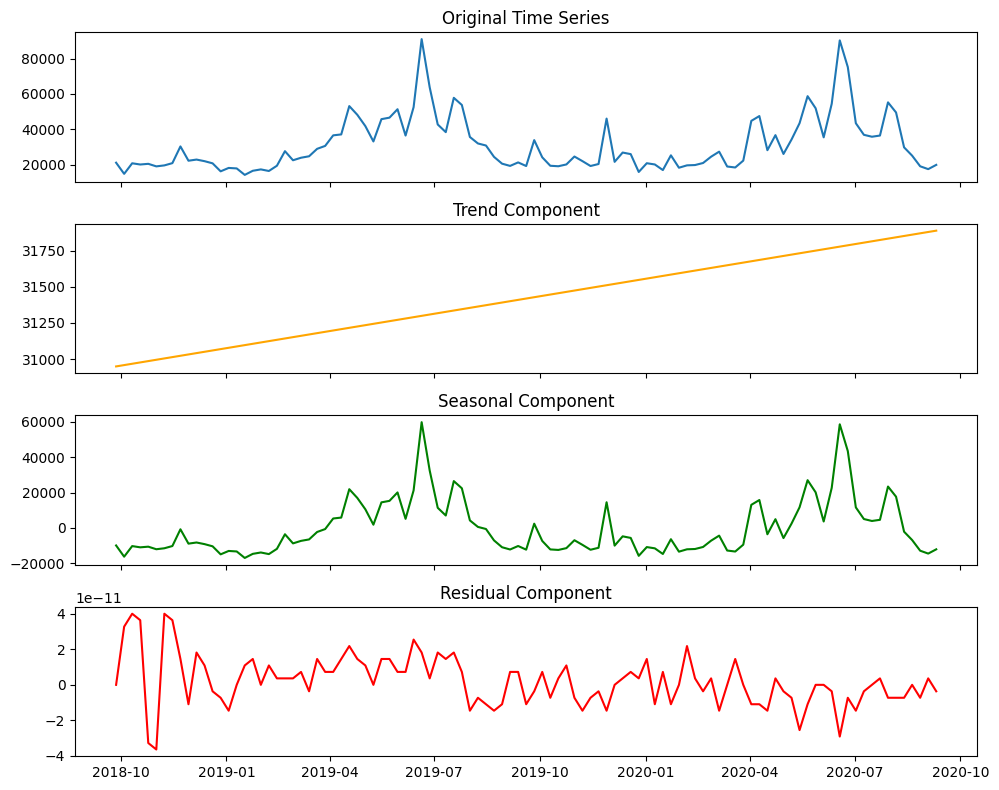

In [15]:
# Perform STL decomposition
stl = STL(df['Dress'], seasonal=13)
result = stl.fit()

# Plot the components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax1.plot(df['Dress'], label='Original Time Series')
ax1.set_title('Original Time Series')

ax2.plot(result.trend, label='Trend Component', color='orange')
ax2.set_title('Trend Component')

ax3.plot(result.seasonal, label='Seasonal Component', color='green')
ax3.set_title('Seasonal Component')

ax4.plot(result.resid, label='Residual Component', color='red')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()

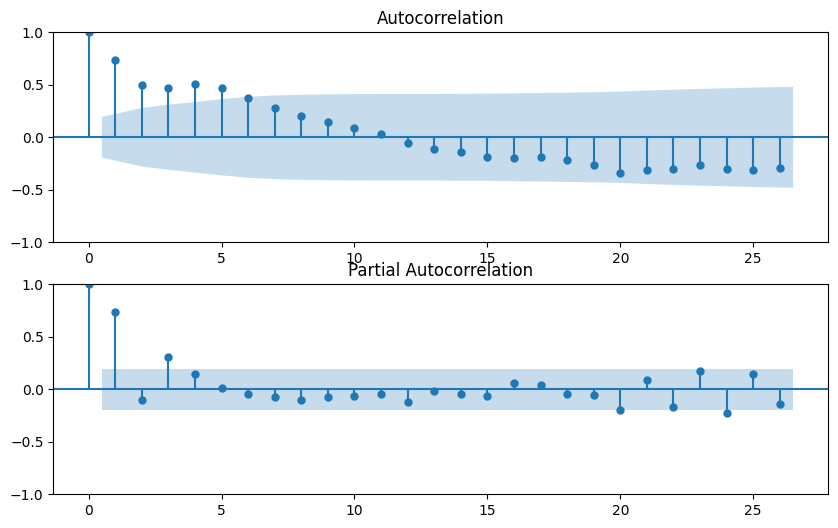

In [16]:
# Function to plot autocorrelation and partial autocorrelation functions
def plot_acf_pacf(timeseries, lags=30):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(timeseries, lags=lags, ax=ax1)
    plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
# Autocorrelation and Partial Autocorrelation Analysis
plot_acf_pacf(result.seasonal, lags=26)

### Correlation matrix

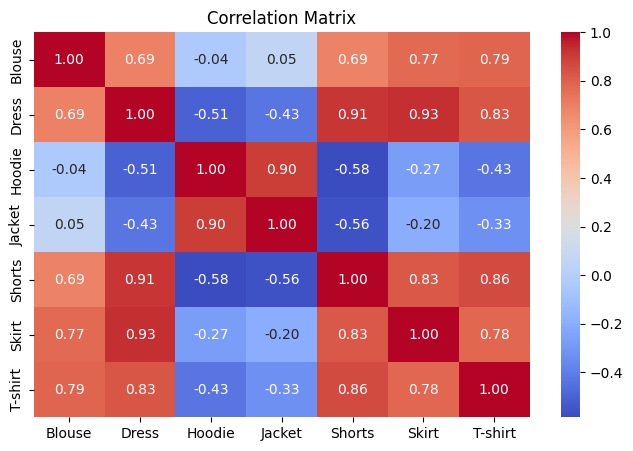

In [17]:
# Function to plot correlation matrix
def plot_correlation_matrix(data):
    corr_matrix = data.corr()
    plt.figure(figsize=(8, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Correlation Analysis
plot_correlation_matrix(df)

In [18]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Perform hypothesis testing for significance
def correlation_test(product1, product2):
    correlation_coefficient, p_value = pearsonr(df[product1], df[product2])
    print(f"Correlation between {product1} and {product2}: {correlation_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("The correlation is statistically significant.\n")
    else:
        print("The correlation is not statistically significant.\n")

# Perform tests for all pairs of products in the correlation matrix
for product1 in correlation_matrix.columns:
    for product2 in correlation_matrix.index:
        if product1 != product2:
            correlation_test(product1, product2)

Correlation between Blouse and Dress: 0.69
P-value: 0.0000
The correlation is statistically significant.

Correlation between Blouse and Hoodie: -0.04
P-value: 0.7066
The correlation is not statistically significant.

Correlation between Blouse and Jacket: 0.05
P-value: 0.5829
The correlation is not statistically significant.

Correlation between Blouse and Shorts: 0.69
P-value: 0.0000
The correlation is statistically significant.

Correlation between Blouse and Skirt: 0.77
P-value: 0.0000
The correlation is statistically significant.

Correlation between Blouse and T-shirt: 0.79
P-value: 0.0000
The correlation is statistically significant.

Correlation between Dress and Blouse: 0.69
P-value: 0.0000
The correlation is statistically significant.

Correlation between Dress and Hoodie: -0.51
P-value: 0.0000
The correlation is statistically significant.

Correlation between Dress and Jacket: -0.43
P-value: 0.0000
The correlation is statistically significant.

Correlation between Dress and 

### ARIMA Modeling

This code performs the following:

* Trains ARIMA on the training dataset and forecasts for the validation period.
* Calculates the MSE, Mean Absolute Percentage Error, MAE for the validation dataset.
* Trains ARIMA model on the complete history and forecasts for the next 5 weeks, including confidence intervals.
* Plots the results

Mean Squarred Error: 48499750
Mean Absolute Percentage Error: 0.15189365200984167
Accuracy (in %): 84.81063479901583
Mean Absolute Error: 5031.214666273935


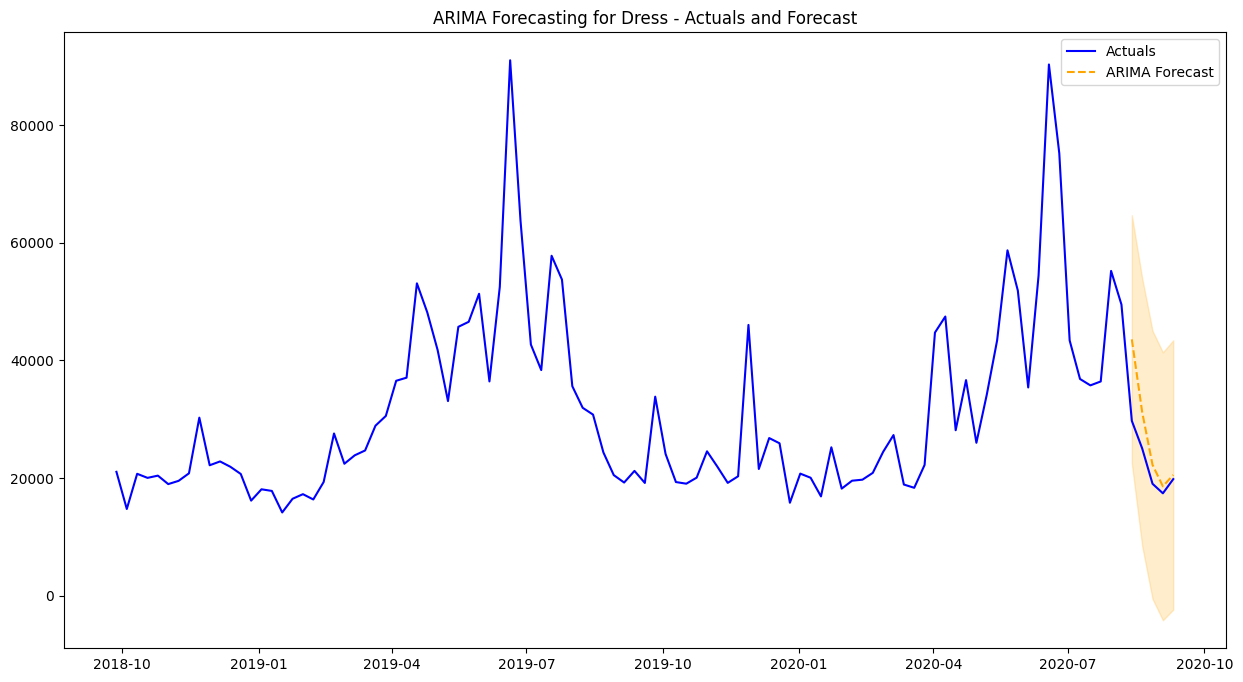

In [19]:
def prepare_data(df, product_type):
    data = df.copy()
    data = data.reset_index()
    data = data[['date', product_type]].rename(columns={'date': 'ds', product_type: 'y'})
    return data

def split_train_validation(data, forecast_period):
    validation_end_date = data['ds'].max()
    validation_start_date = validation_end_date - timedelta(weeks=forecast_period-1)
    validation = data[data['ds'].between(validation_start_date, validation_end_date)]
    train_end_date = validation_start_date - timedelta(days=1)
    train = data[data['ds'] <= train_end_date]
    return train, validation

def fit_predict_arima(train, forecast_period):
    # Fit ARIMA model
    order = (2, 1, 2)
    seasonal_order = (0, 1, 1, 52)
    arima_model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order)
    arima_fit = arima_model.fit(disp=False)

    # Predict using the fitted model
    arima_forecast = arima_fit.get_forecast(steps=forecast_period)
    arima_conf_int = arima_forecast.conf_int(alpha=0.05)

    return arima_forecast.predicted_mean.values, arima_conf_int.values
    
def plot_arima_results(train, validation, arima_forecast, conf_int_arima, forecast_period):
    
    data = pd.concat([train, validation], ignore_index=True)
    
    if len(validation)>0:
        print("Mean Squarred Error:", round(mean_squared_error(arima_forecast,validation['y'])))
        print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(arima_forecast,validation['y']))
        print("Accuracy (in %):", 100*(1 - mean_absolute_percentage_error(arima_forecast,validation['y'])))
        print("Mean Absolute Error:", mean_absolute_error(arima_forecast,validation['y']))
    
    plt.figure(figsize=(15, 8))

    # Training + Validation data
    plt.plot(data['ds'], data['y'], color='blue', label='Actuals')

    # ARIMA Forecast
    future_dates = pd.date_range(start=train['ds'].max() + timedelta(weeks=1), periods=forecast_period, freq='W-THU')
    plt.plot(future_dates, arima_forecast, color='orange', linestyle='dashed', label='ARIMA Forecast')
    plt.fill_between(future_dates, conf_int_arima[:, 0], conf_int_arima[:, 1], color='orange', alpha=0.2)
    plt.title(f'ARIMA Forecasting for {product_type} - Actuals and Forecast')
    plt.legend()
    plt.show()
    
# Choose a product type (e.g., 'Blouse') for forecasting
product_type = 'Dress'
forecast_period = 5
data = df.copy()
    
# Prepare data
data = prepare_data(data, product_type)

# Split data into train and validation sets
train, validation = split_train_validation(data, forecast_period)

# Fit and predict with ARIMA
arima_forecast, conf_int_arima = fit_predict_arima(train, forecast_period)

# Plot validation period forecast
plot_arima_results(train, validation, arima_forecast, conf_int_arima, forecast_period)

### ARIMA Forecast

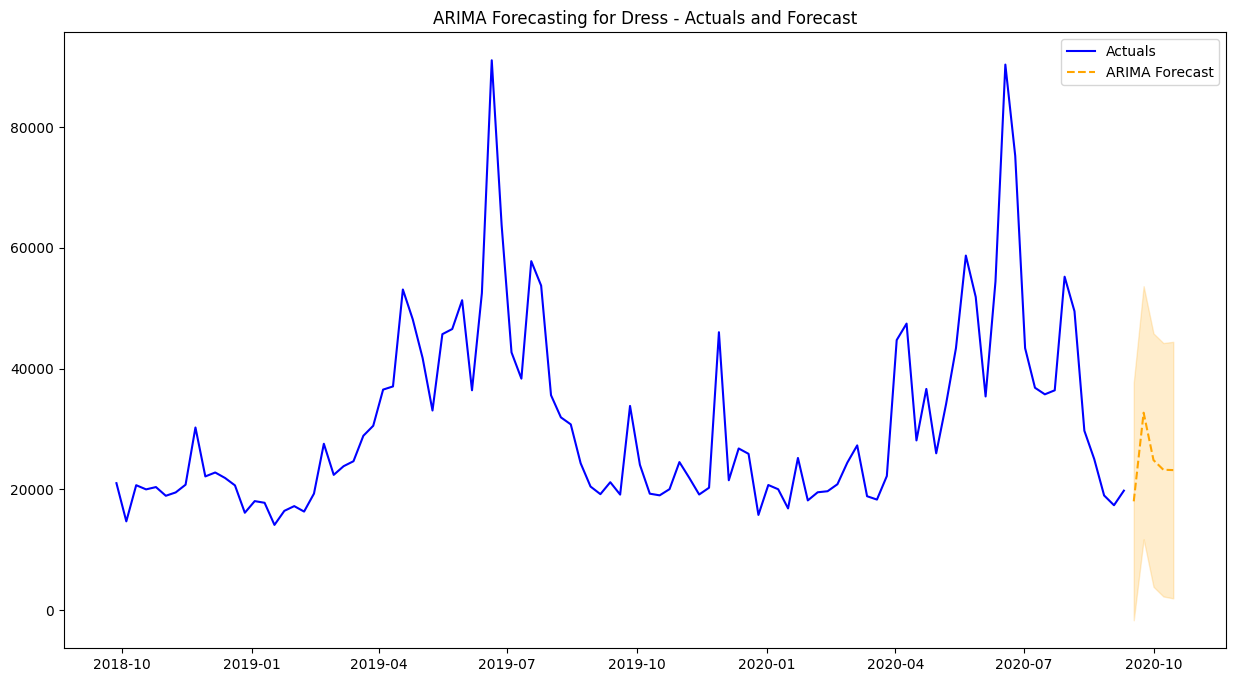

In [20]:
# Fit and predict with ARIMA
arima_forecast, conf_int_arima = fit_predict_arima(data, forecast_period)

# Plot future period forecast
plot_arima_results(data, pd.DataFrame(), arima_forecast, conf_int_arima, forecast_period)